In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from nero import Harmonia
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings

import matplotlib.patches as patches
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False

In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [4]:
with open('/myvol/data2/10x/20191102/liver1.pkl','rb') as file:
    liver1 = pkl.load(file)
    adata = liver1['adata']

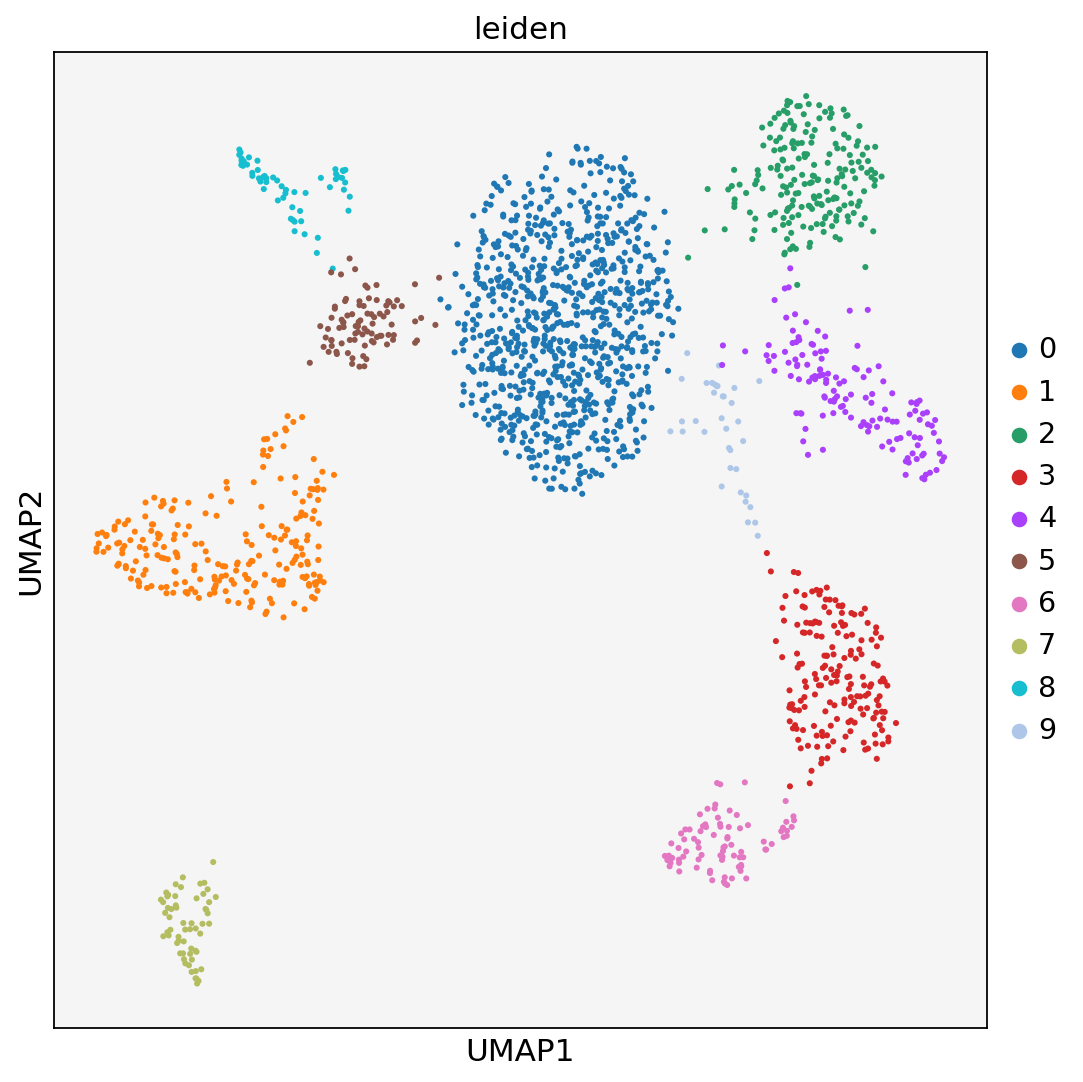

In [5]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.set_facecolor('whitesmoke')
sc.pl.umap(adata,color='leiden',ax=ax, size=30, return_fig=False, show=False)
plt.tight_layout()

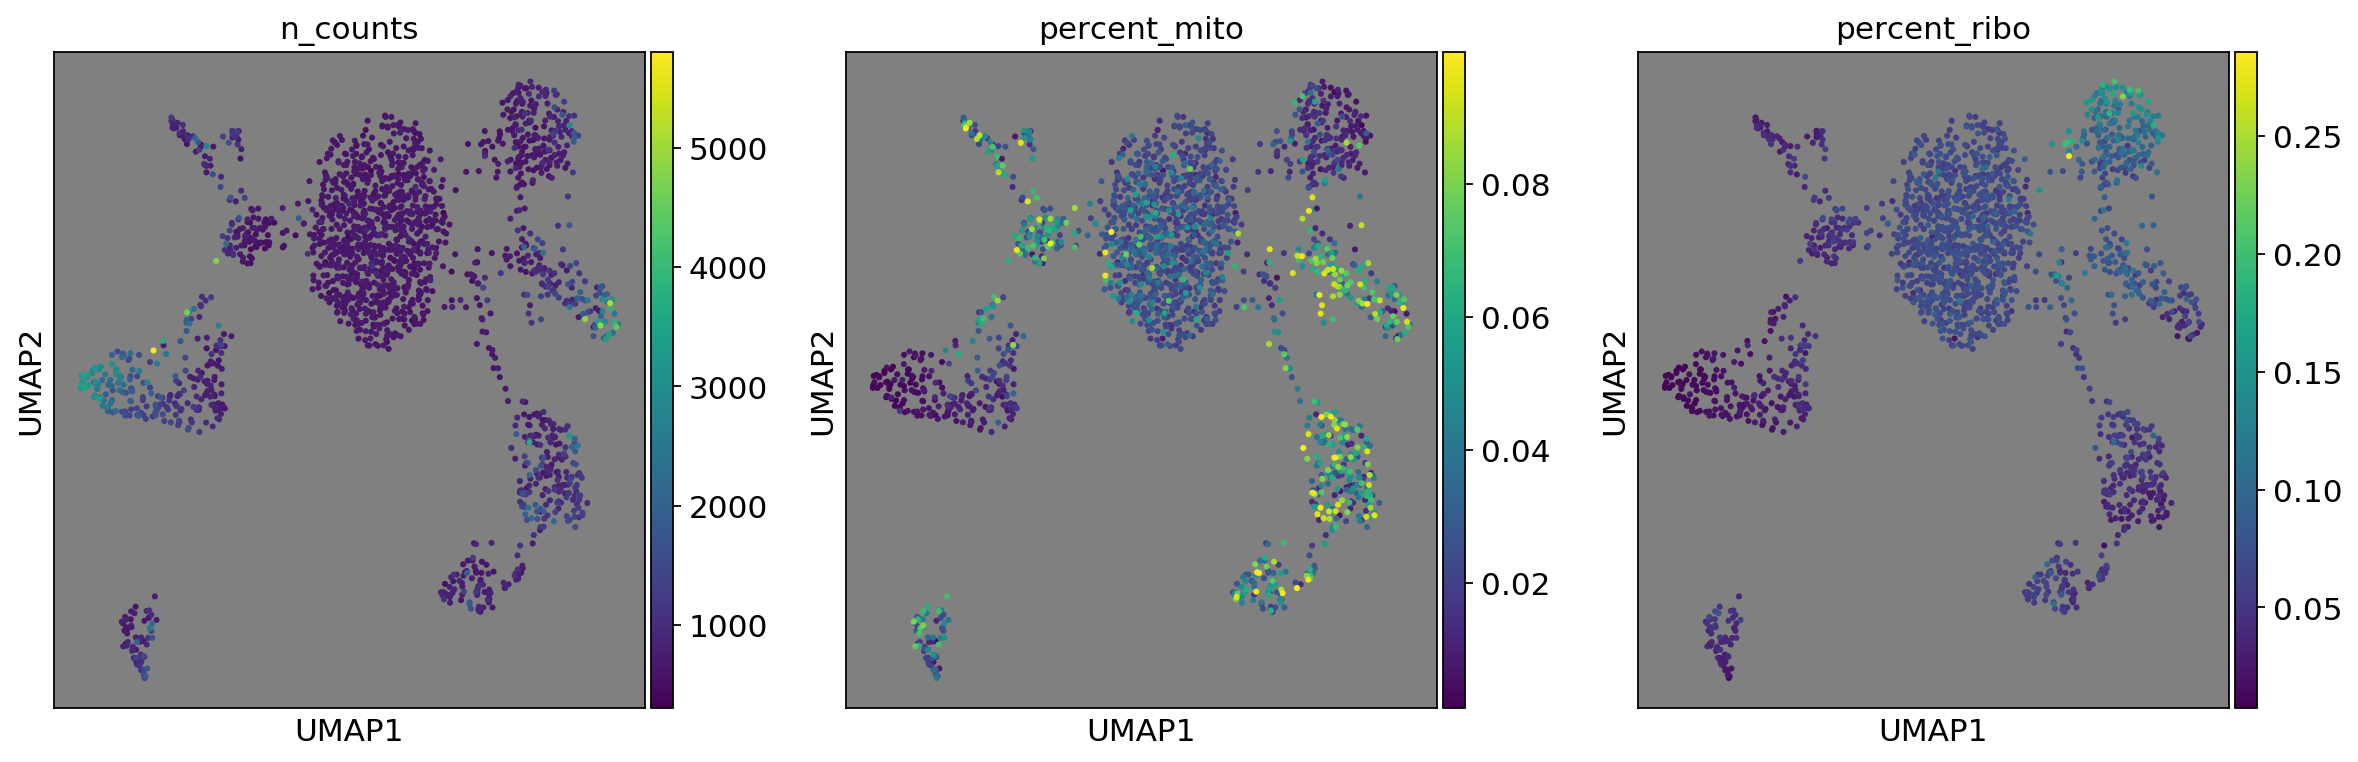

In [8]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
colorby = ['n_counts','percent_mito','percent_ribo']
for c, ax in zip(colorby, np.ravel(axes)):
    ax.set_facecolor('gray')
    sc.pl.umap(adata,color=c,ax=ax, size=30, return_fig=False, show=False)
plt.tight_layout()

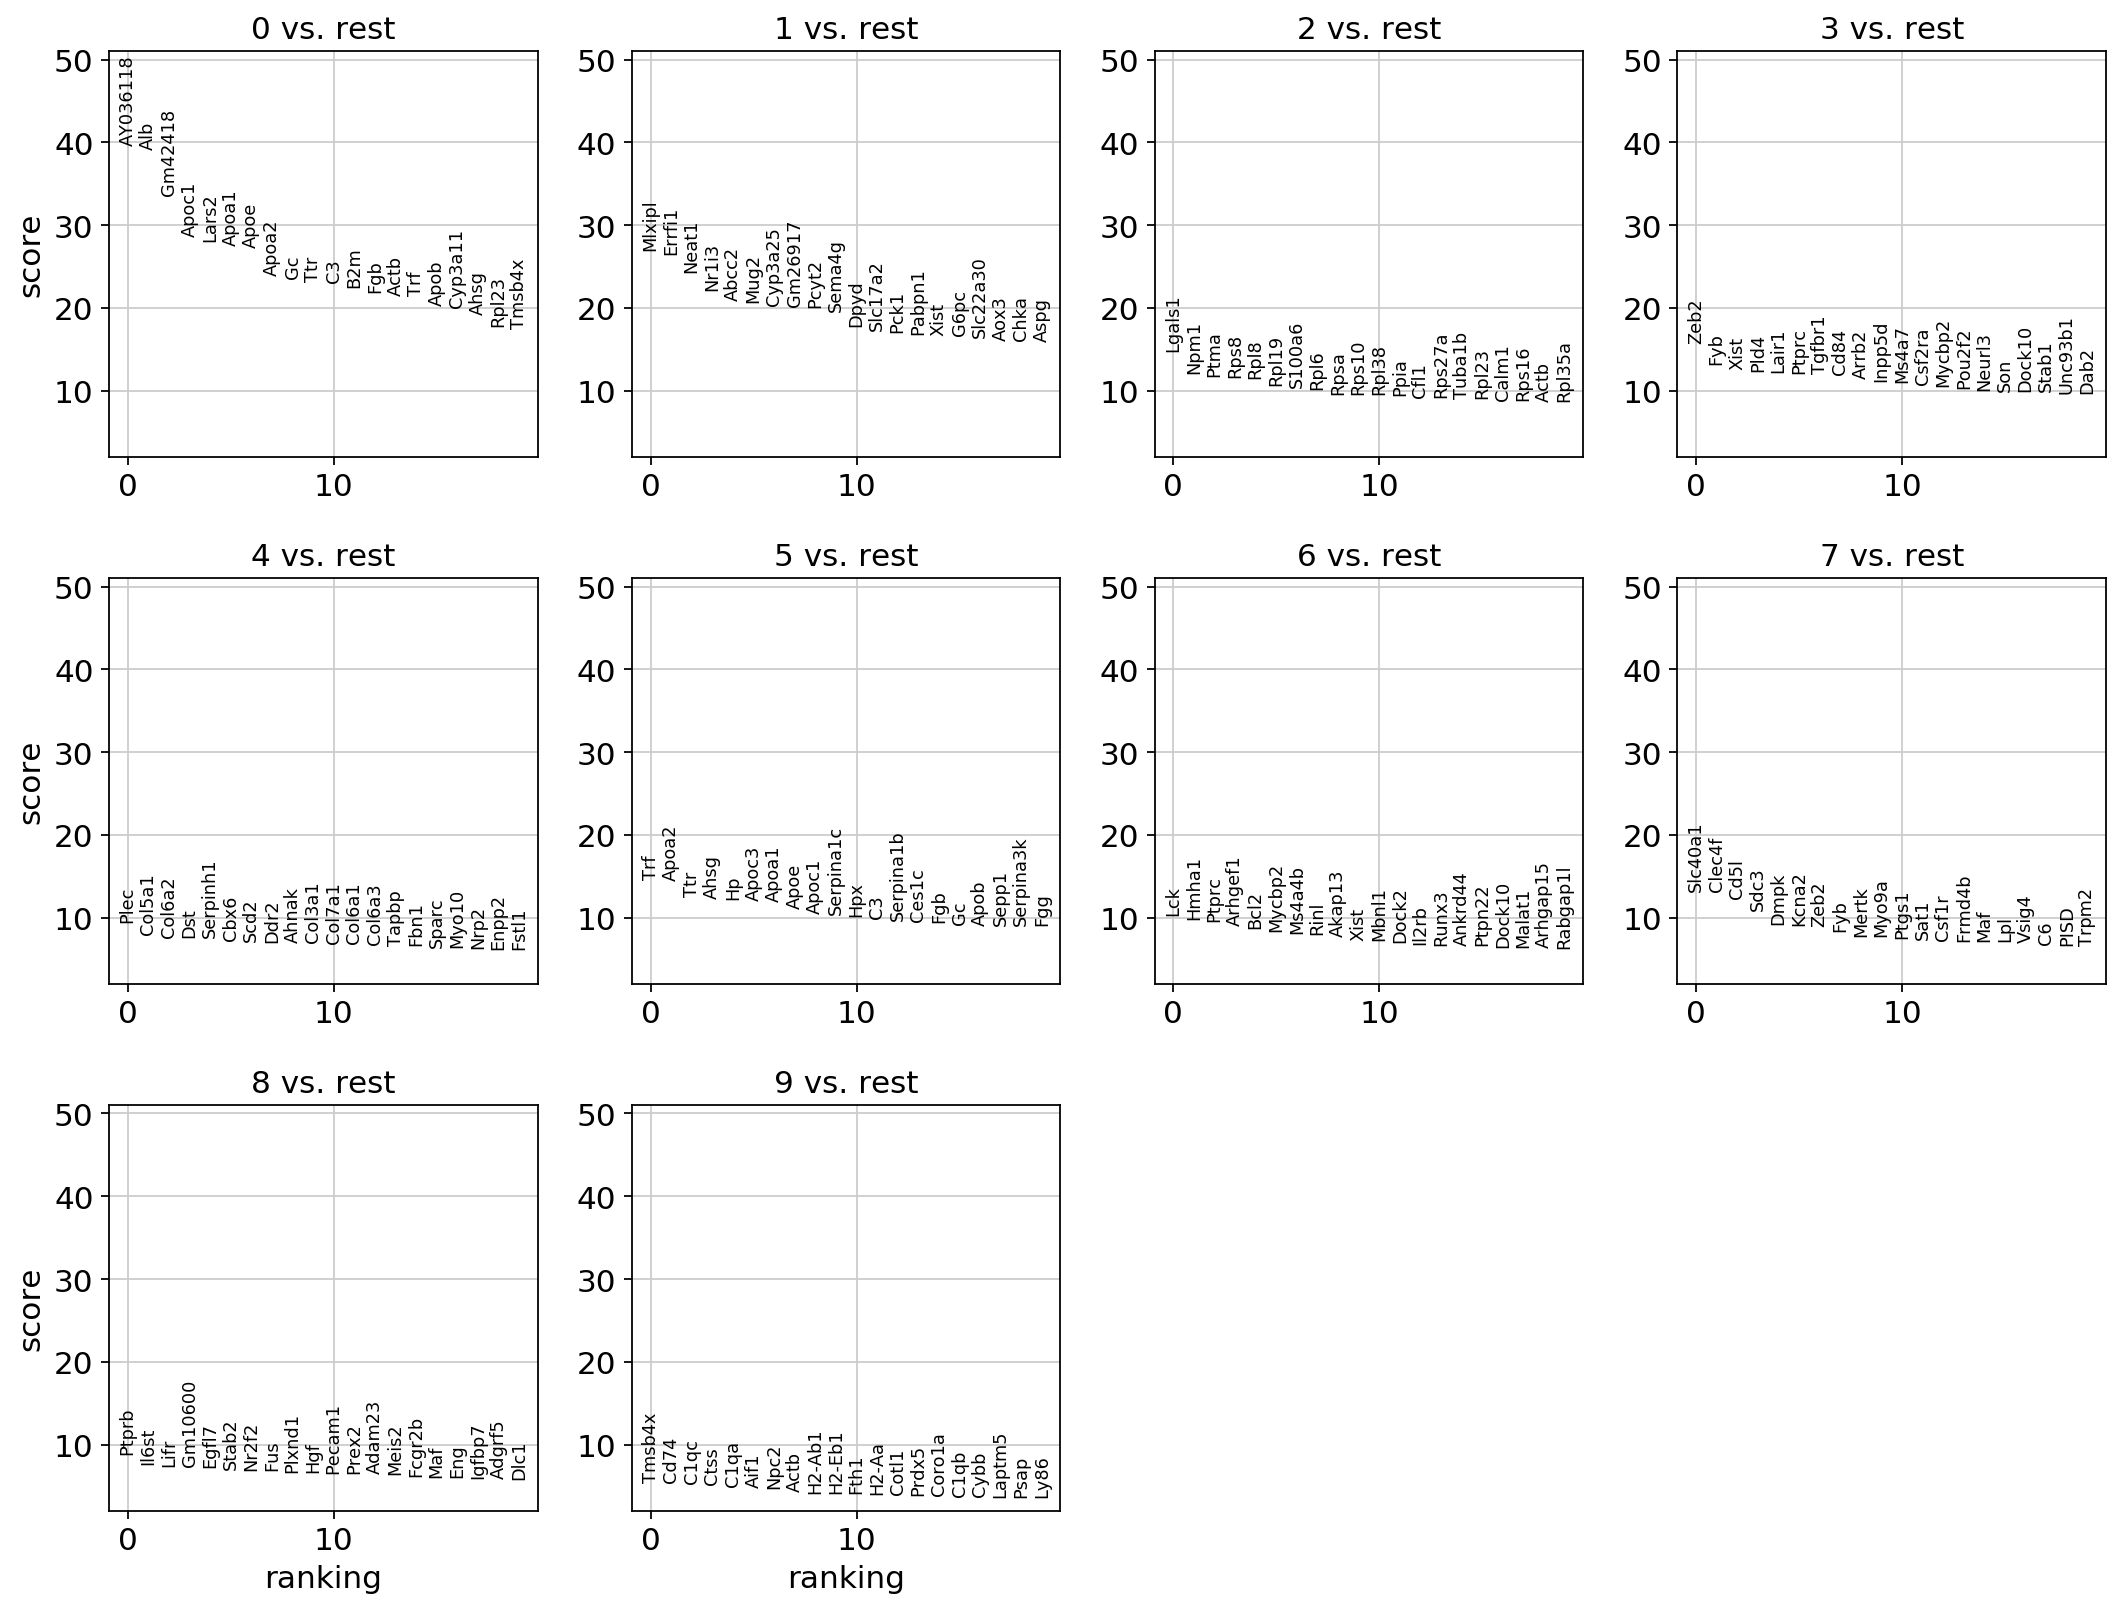

In [9]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata,groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(adata)
sc.settings.verbosity = 3

In [8]:
def hv_run(adata,min_mean=0.0125, min_disp=0.5, max_mean=3):    # Extract out highly variable genes, but don't subset just yet.
    hv_adata = adata.copy()
    sc.pp.highly_variable_genes(hv_adata, flavor='cell_ranger',inplace=True, 
                                min_mean=min_mean, 
                                min_disp=min_disp, 
                                max_mean=max_mean,
                                n_bins=500)
    return hv_adata

def hv_plot(hv_adata, gate=None, highlight_genes=None):
    plt.figure(figsize=(7,7))
    plt.minorticks_on()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True,which='both',axis='both')
    plt.plot(hv_adata.var['means'].values,hv_adata.var['dispersions_norm'].values,linewidth=0, marker='.',markersize=0.5, color='b');
    if type(highlight_genes) != type(None):
        mask = [i in highlight_genes for i in hv_adata.var_names]
        highlight_means = hv_adata.var['means'].values[mask]
        highlight_disps = hv_adata.var['dispersions_norm'].values[mask]
        plt.plot(highlight_means,highlight_disps,linewidth=0, marker='o',markersize=10, color='r', mfc='none');
    ax = plt.gca()
    if type(gate) != type(None):
        gatepatch = patches.Polygon(gate,linewidth=1,edgecolor='teal',facecolor='turquoise',alpha=0.5)
        ax.add_patch(gatepatch);

def hv_genes(hv_adata, gate, adata=None):
    '''
    Receive boolean for genes in gate or new subsetted adata object, if provided.
    '''
    genes = list()
    means = hv_adata.var['means'].values
    disps = hv_adata.var['dispersions_norm'].values
    pointsmap = map(Point,means,disps)
    polygon = Polygon(gate)
    for i in pointsmap:
        genes.append(polygon.contains(i))
    if type(adata) != type(None):
        adata = adata[:,genes].copy()
        return adata
    else:
        return genes

In [34]:
ctdict = dict()
ctdict['Macs'] = [9, 3]
ctdict['Heps'] = [0, 2, 5]
ctdict['LSEC'] = [8]
ctdict['Kup'] = [7]
ctdict['Lymph'] = [6]
ctdict['MC38'] = [1, 4]
adata.obs['celltype'] = adata.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        adata.obs['celltype'].replace(r'^%s$' % str(clust),ct,regex=True, inplace=True)
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

In [74]:
macs = adata[adata.obs['celltype'] == 'Macs'].copy()
heps = adata[adata.obs['celltype'] == 'Heps'].copy()
lsec = adata[adata.obs['celltype'] == 'LSEC'].copy()
lyms = adata[adata.obs['celltype'] == 'Lymph'].copy()

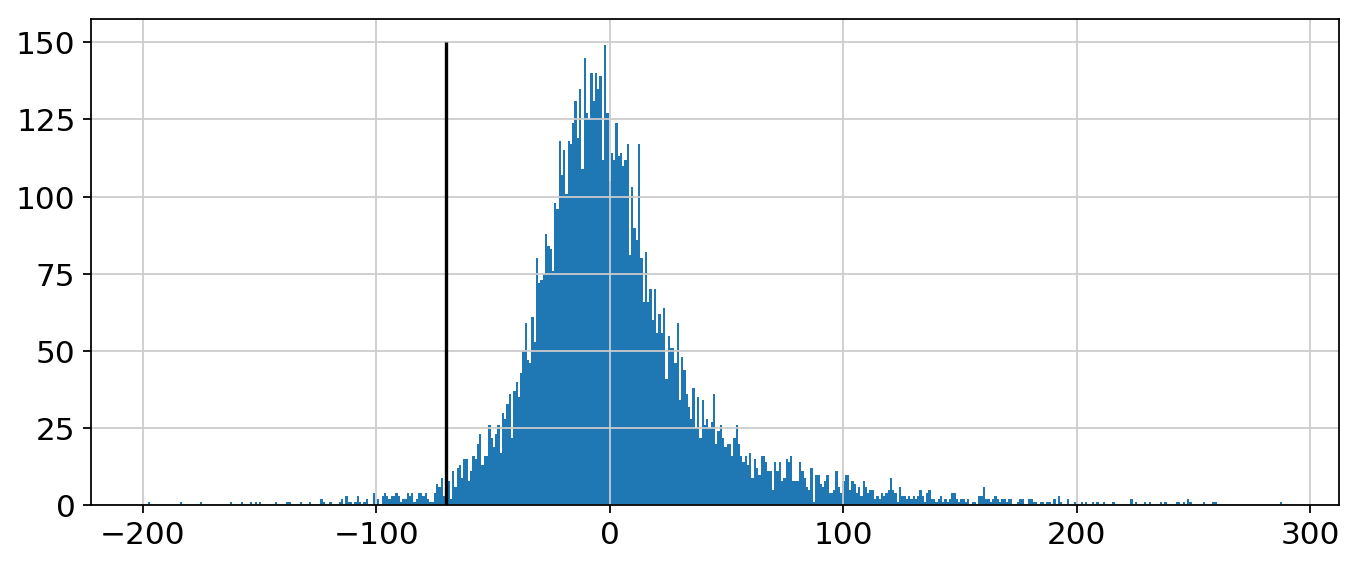

In [75]:
plt.figure(figsize=(10,4))
plt.hist(sc.pp.filter_genes(macs, min_counts=-np.inf, inplace=False)[1], bins=500);
plt.vlines(-70, 0, 150);

In [76]:
sc.pp.filter_genes(macs, min_counts=0)

filtered out 4758 genes that are detectedin less than 0 counts


In [77]:
sc.pp.scale(macs, max_value=10)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:00)


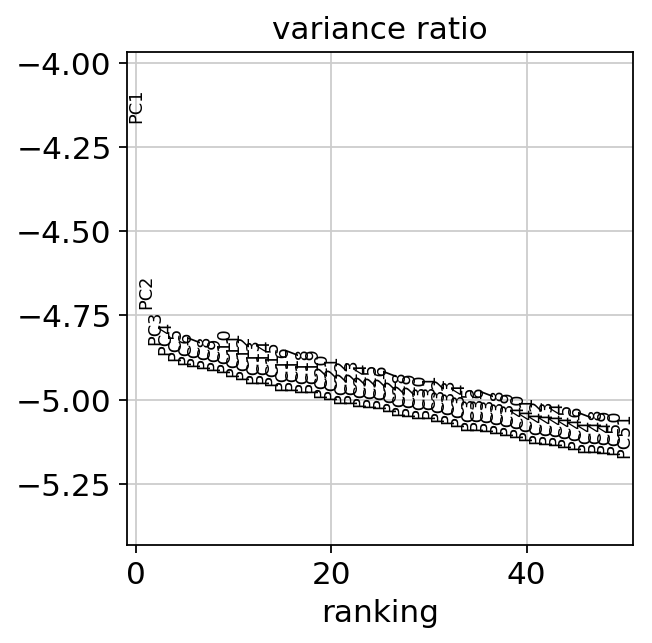

In [78]:
sc.pp.pca(macs,n_comps=100)
sc.pl.pca_variance_ratio(macs,log=True, n_pcs=50)

In [79]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(macs, n_neighbors=15,n_pcs=5) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [87]:
sc.tl.umap(macs)#, min_dist=.05, spread=5, alpha=2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


In [92]:
sc.tl.leiden(macs,resolution=0.2)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


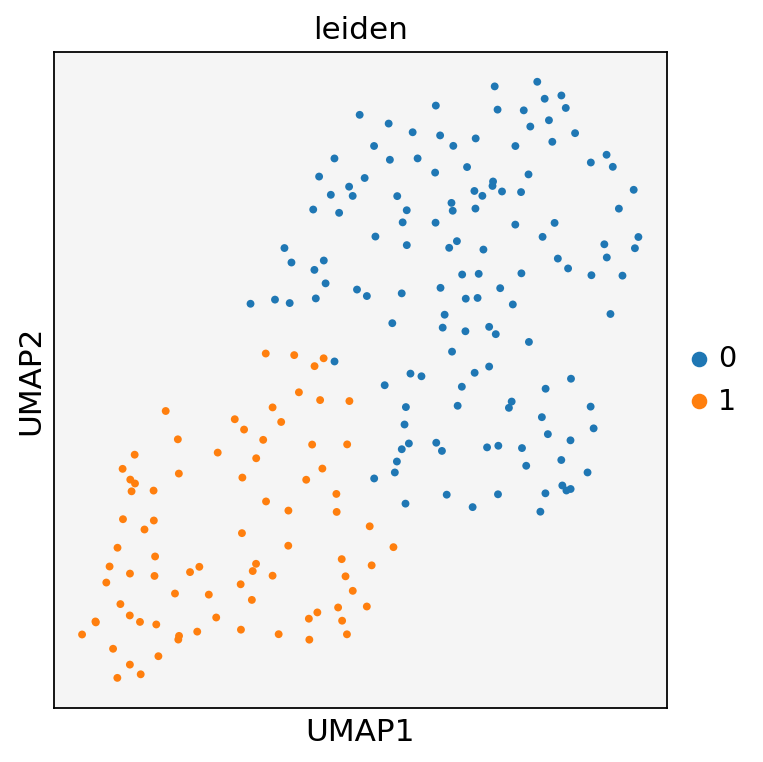

In [105]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_facecolor('whitesmoke')
sc.pl.umap(macs,color='leiden',ax=ax, size=50, return_fig=False, show=False)
plt.tight_layout()

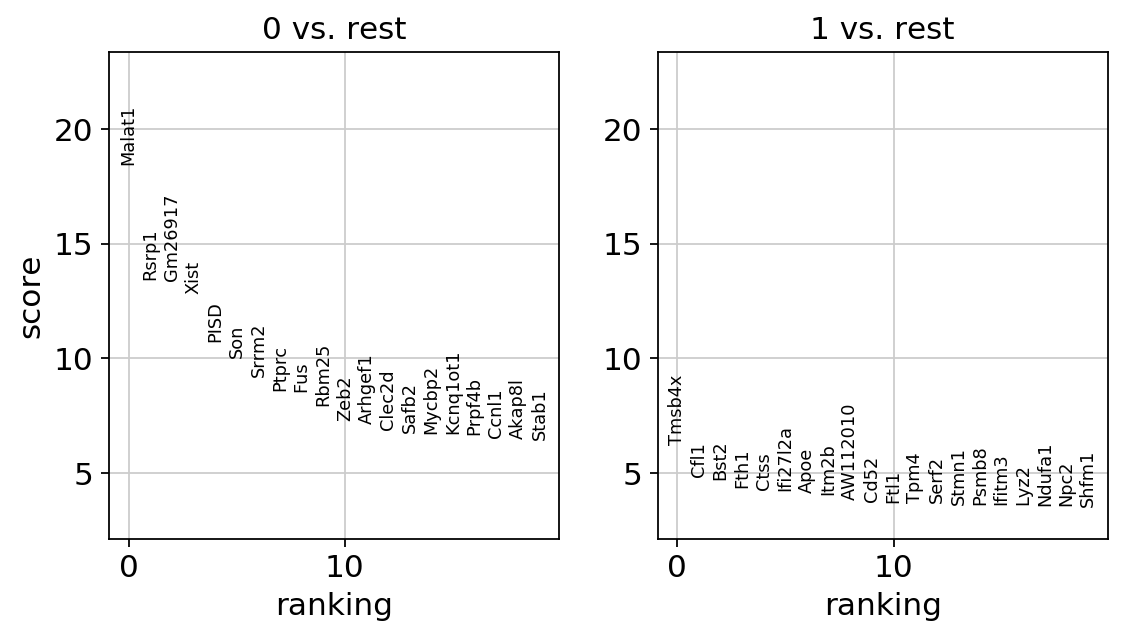

In [94]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(macs,groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(macs)
sc.settings.verbosity = 3

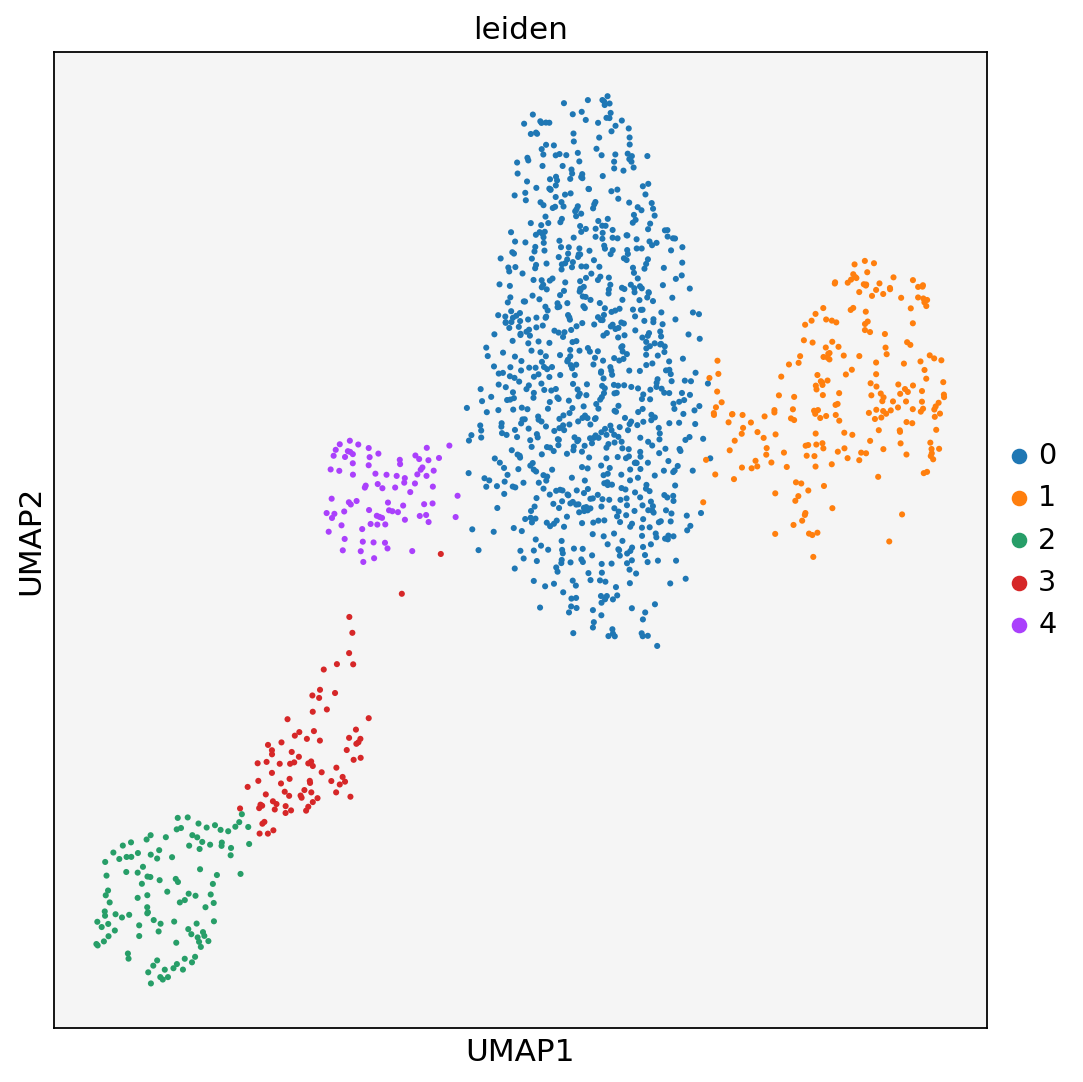

In [33]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.set_facecolor('whitesmoke')
sc.pl.umap(hep,color='leiden',ax=ax, size=30, return_fig=False, show=False)
plt.tight_layout()

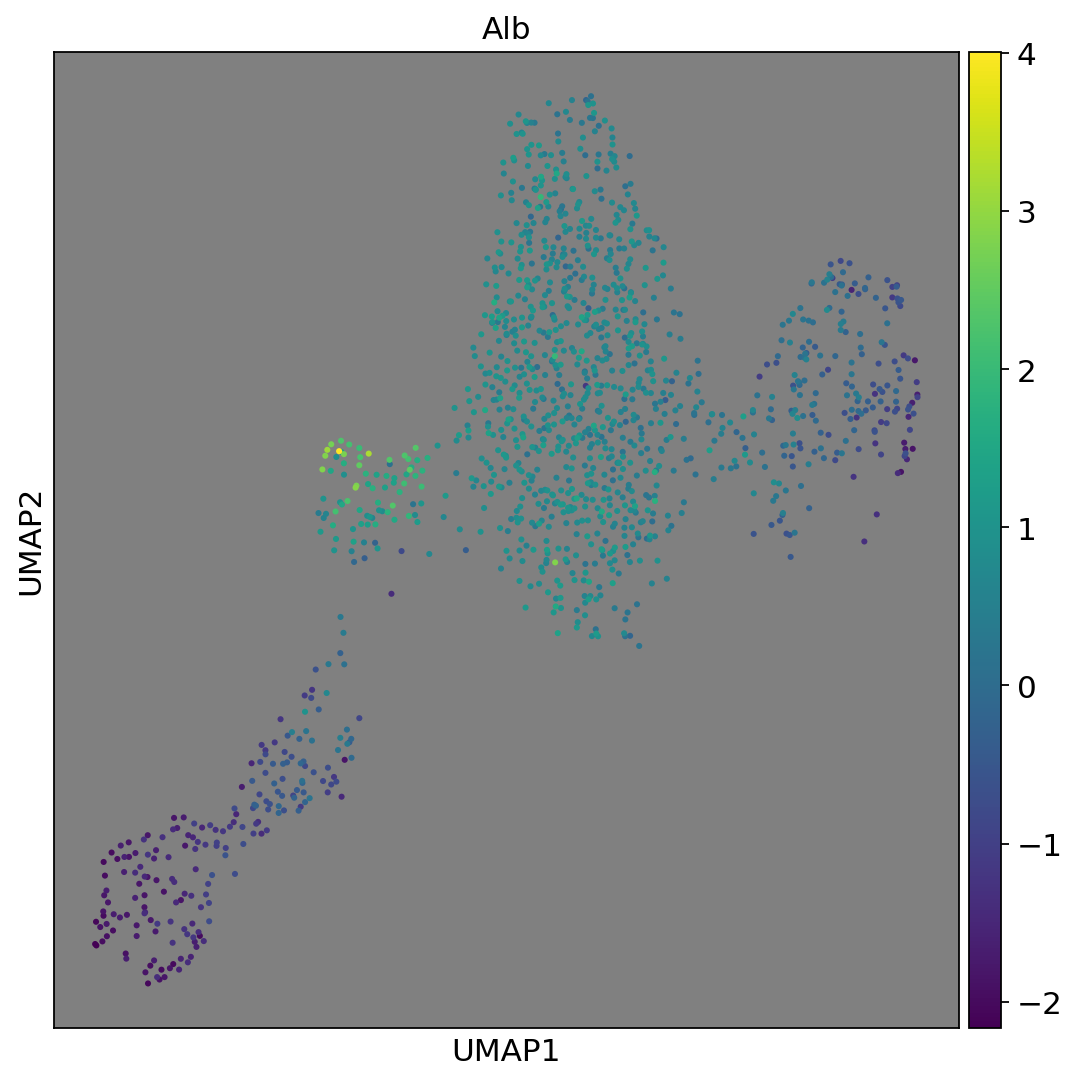

In [88]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.set_facecolor('gray')
sc.pl.umap(hep,color='Alb',ax=ax, size=30, return_fig=False, show=False)
plt.tight_layout()

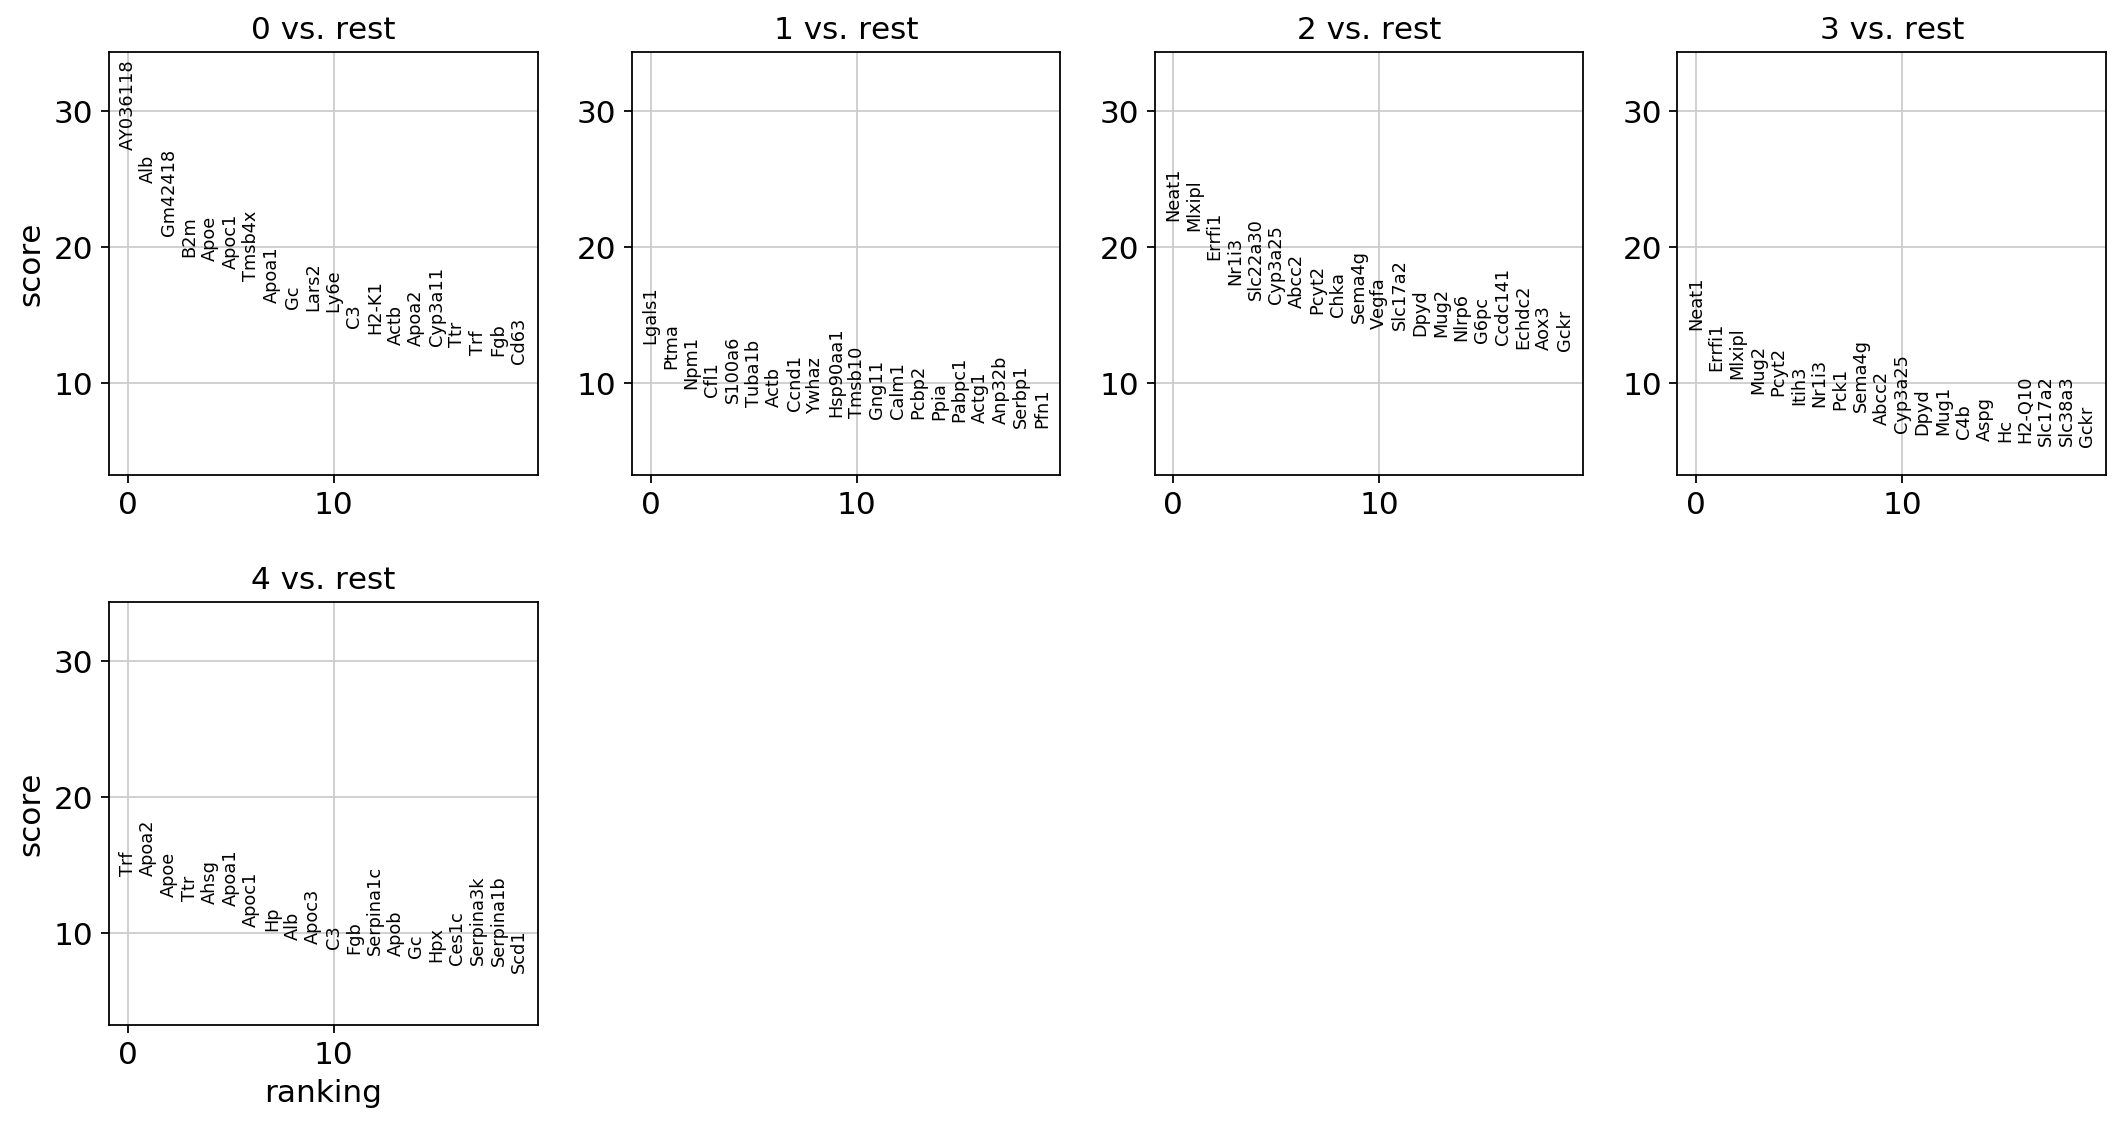

In [60]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(hep,groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(hep)
sc.settings.verbosity = 3

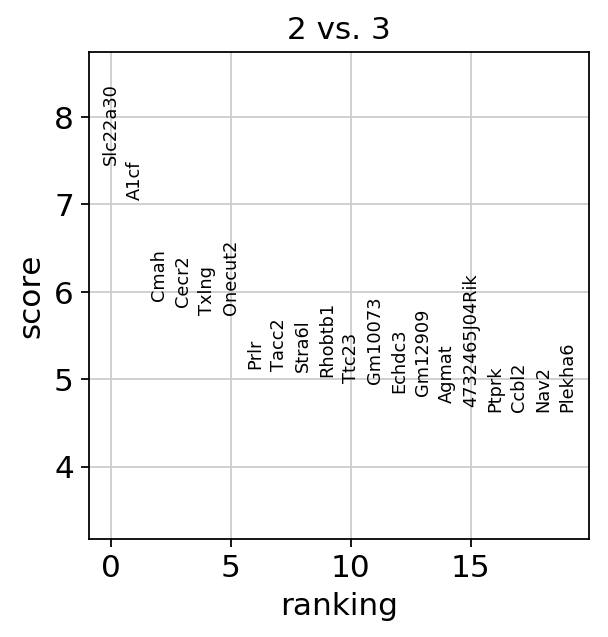

In [62]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(hep,groupby='leiden', groups=['2'],reference='3')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(hep)
sc.settings.verbosity = 3

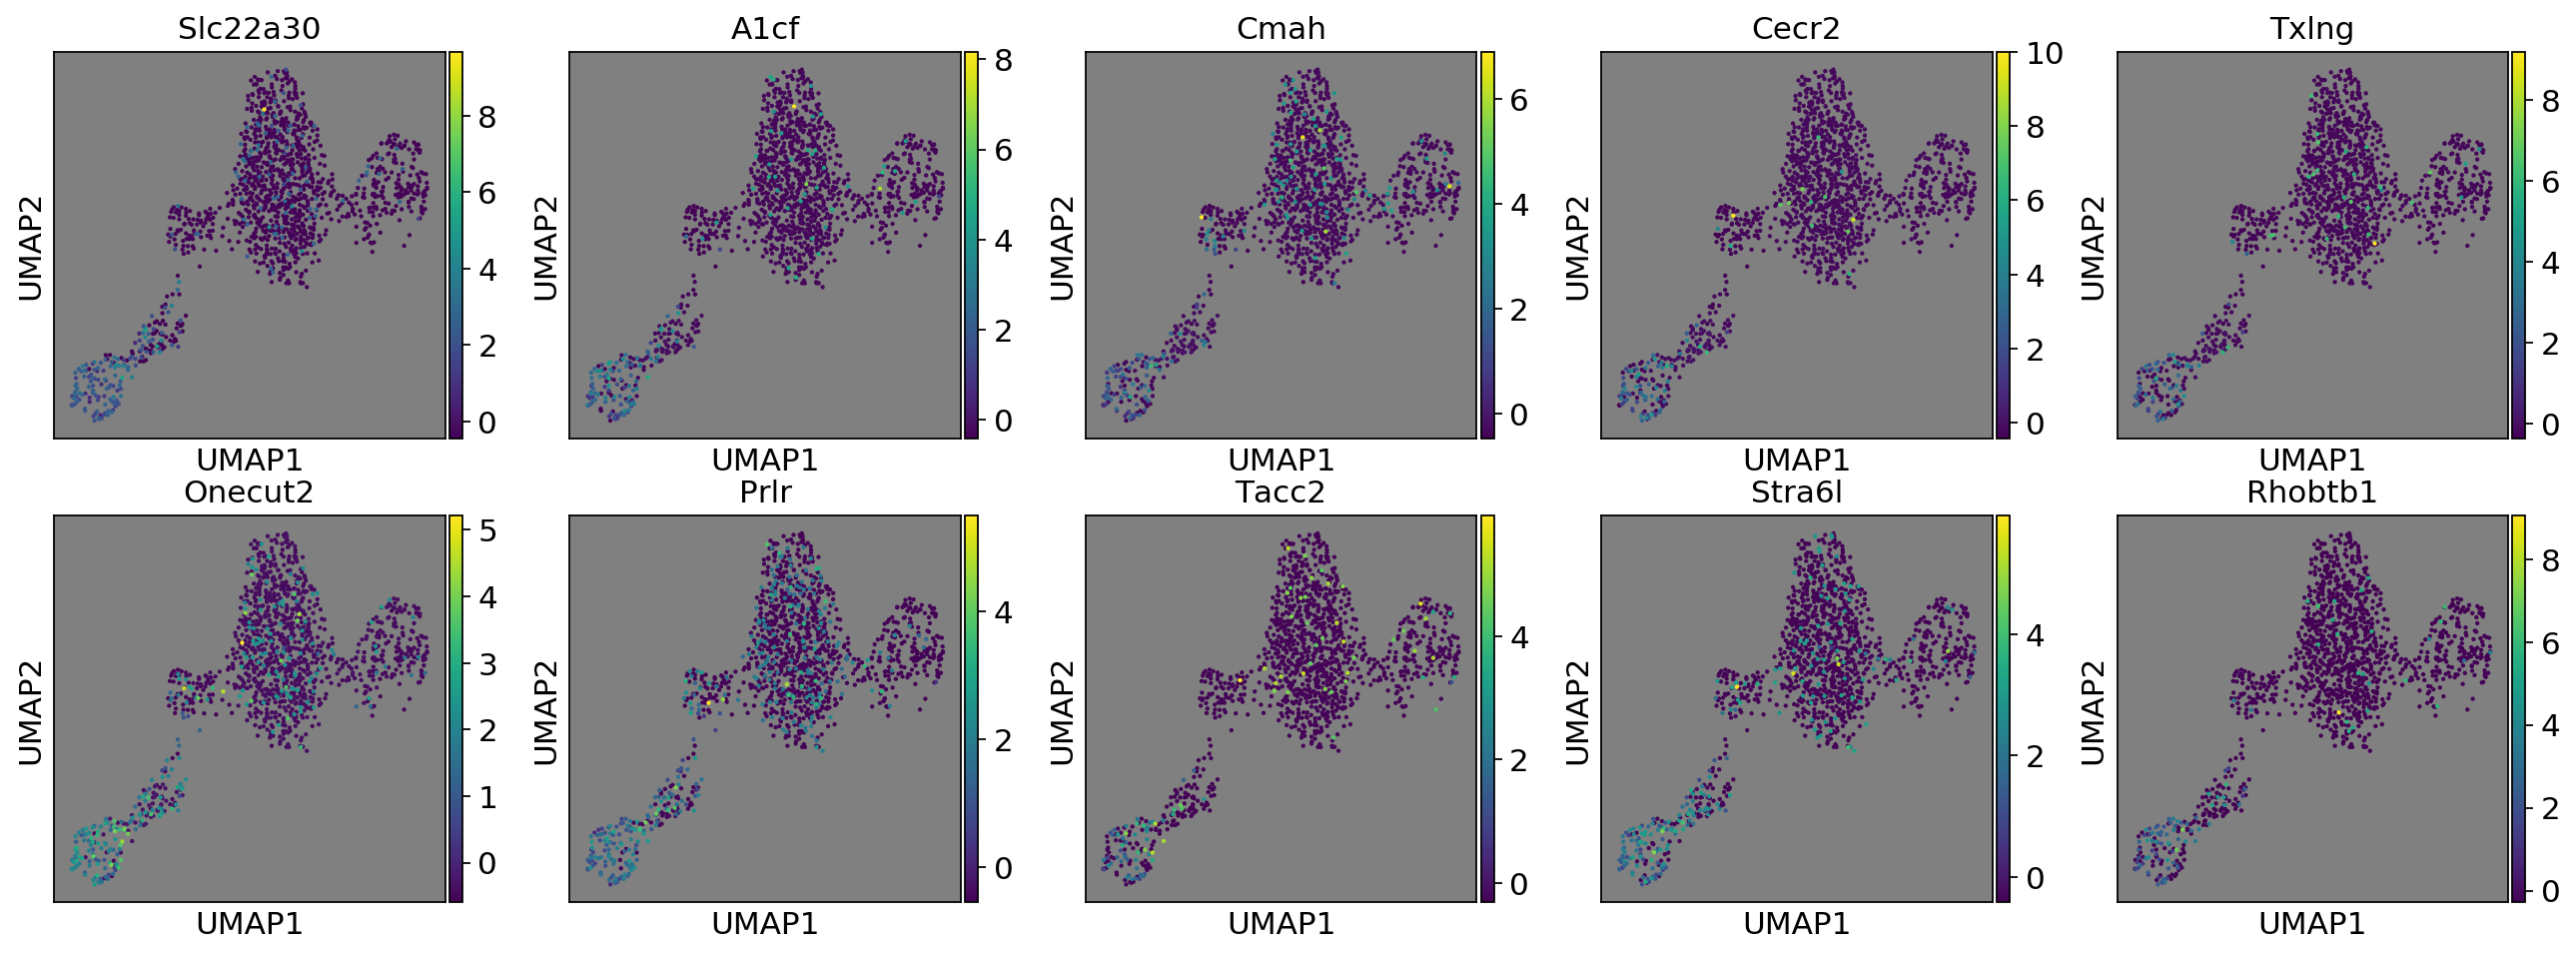

In [65]:
fig, axes = plt.subplots(2,5,figsize=(20,7))
for gene, ax in zip(hep.uns['rank_genes_groups']['names']['2'][:10], np.ravel(axes)):
    ax.set_facecolor('gray')
    sc.pl.umap(hep, color=gene, size=15, ax=ax, show=False, return_fig=False)

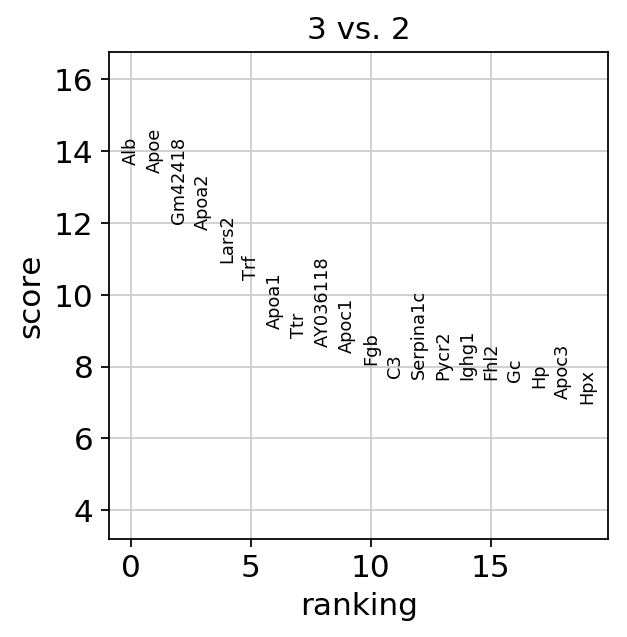

In [66]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(hep,groupby='leiden', groups=['3'],reference='2')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(hep)
sc.settings.verbosity = 3

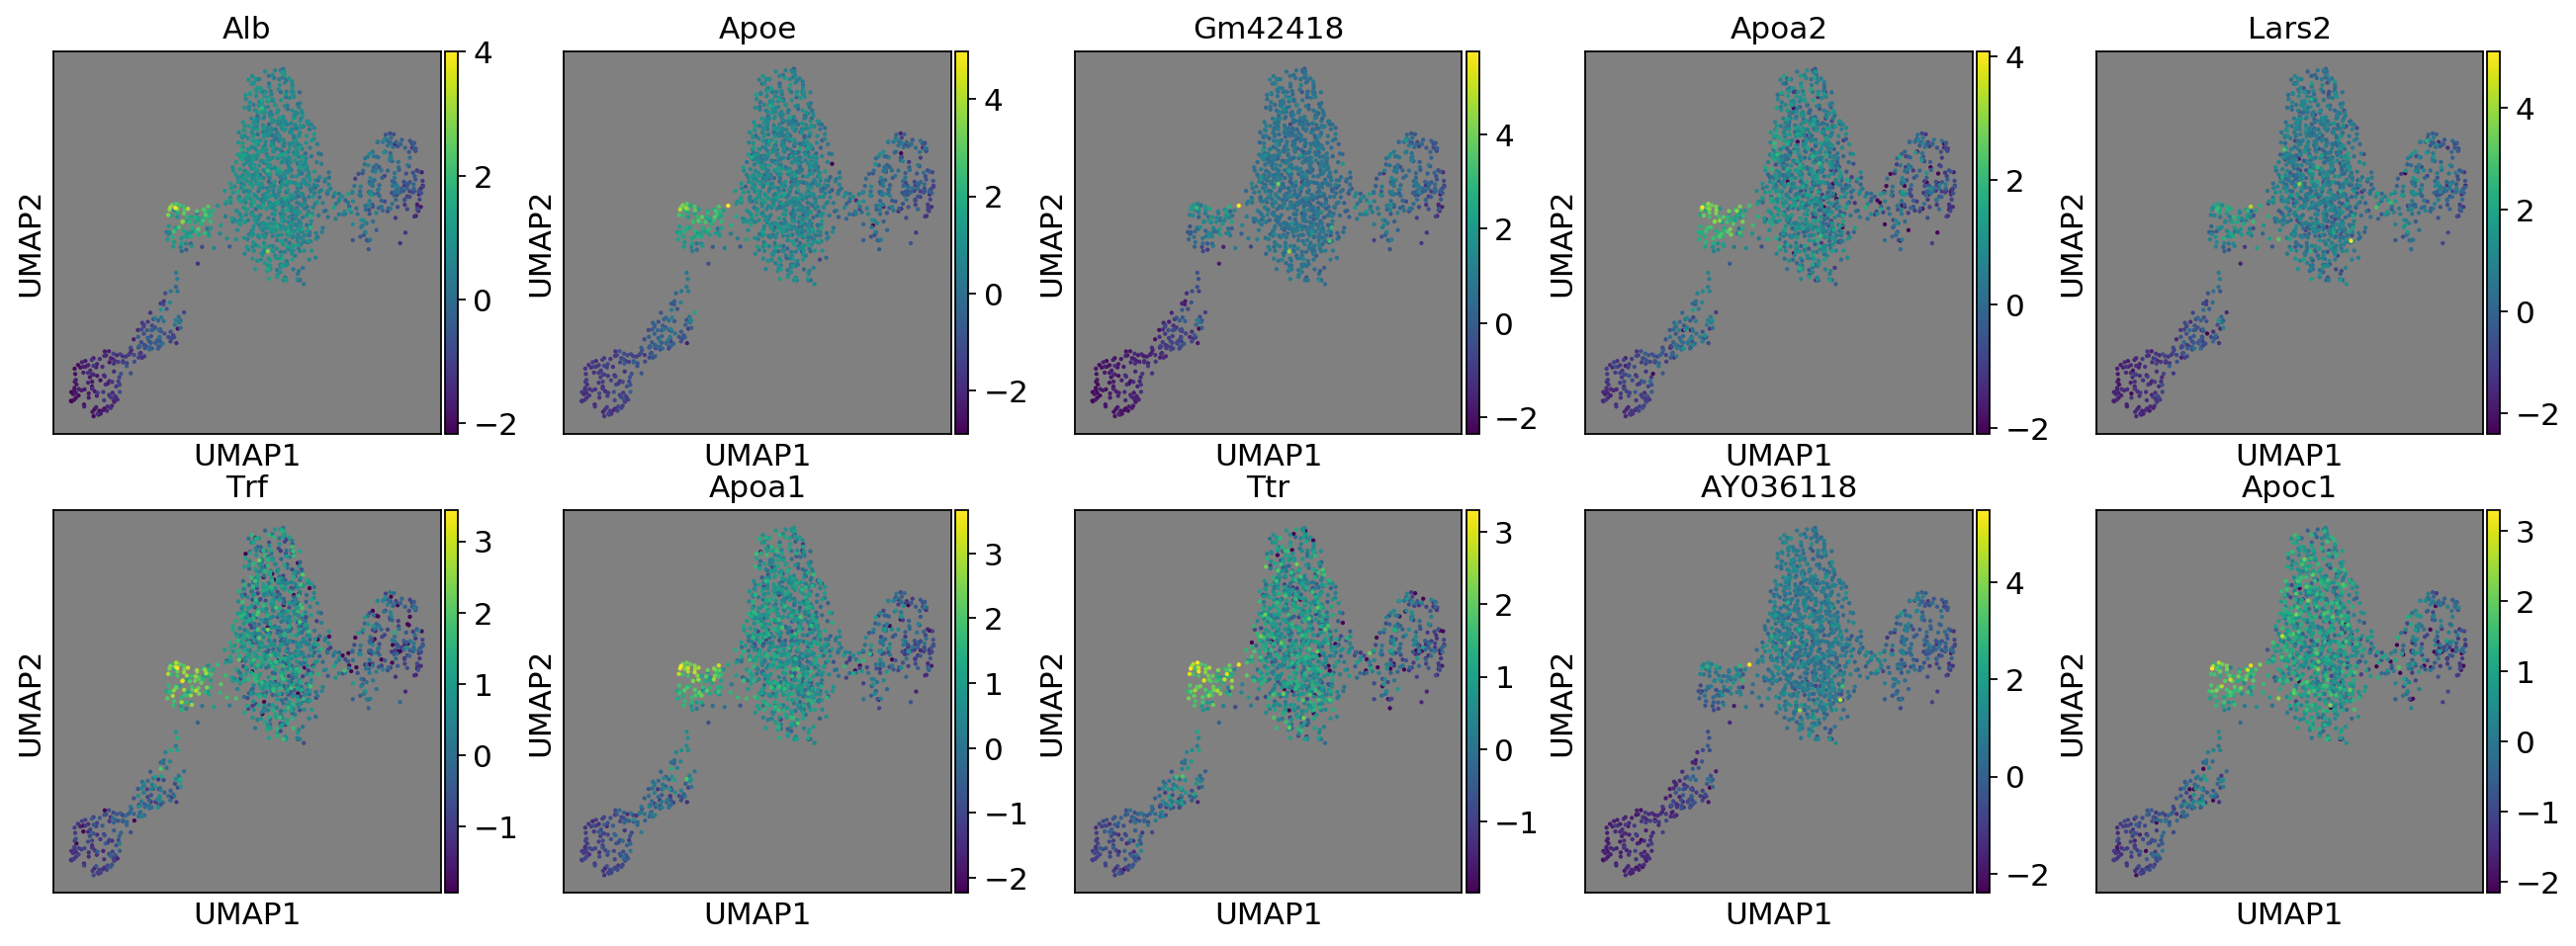

In [67]:
fig, axes = plt.subplots(2,5,figsize=(20,7))
for gene, ax in zip(hep.uns['rank_genes_groups']['names']['3'][:10], np.ravel(axes)):
    ax.set_facecolor('gray')
    sc.pl.umap(hep, color=gene, size=15, ax=ax, show=False, return_fig=False)

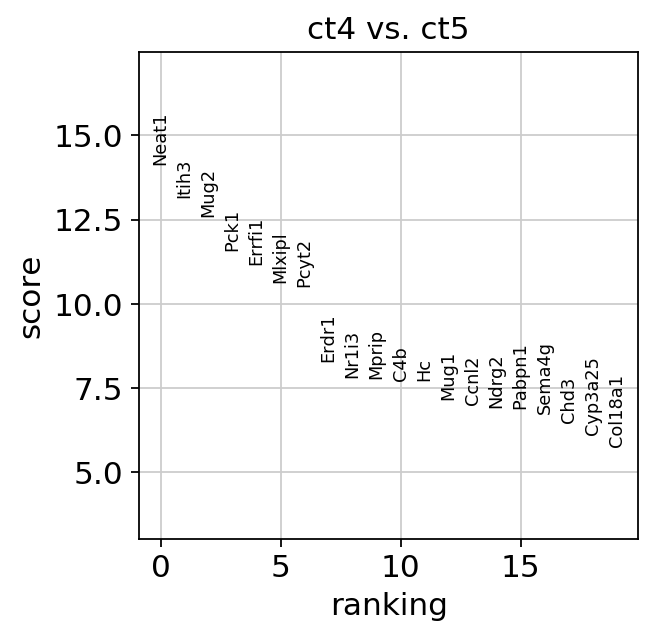

In [295]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(liver,groupby='celltype', groups=['ct4'],reference='ct5')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(liver)
sc.settings.verbosity = 3

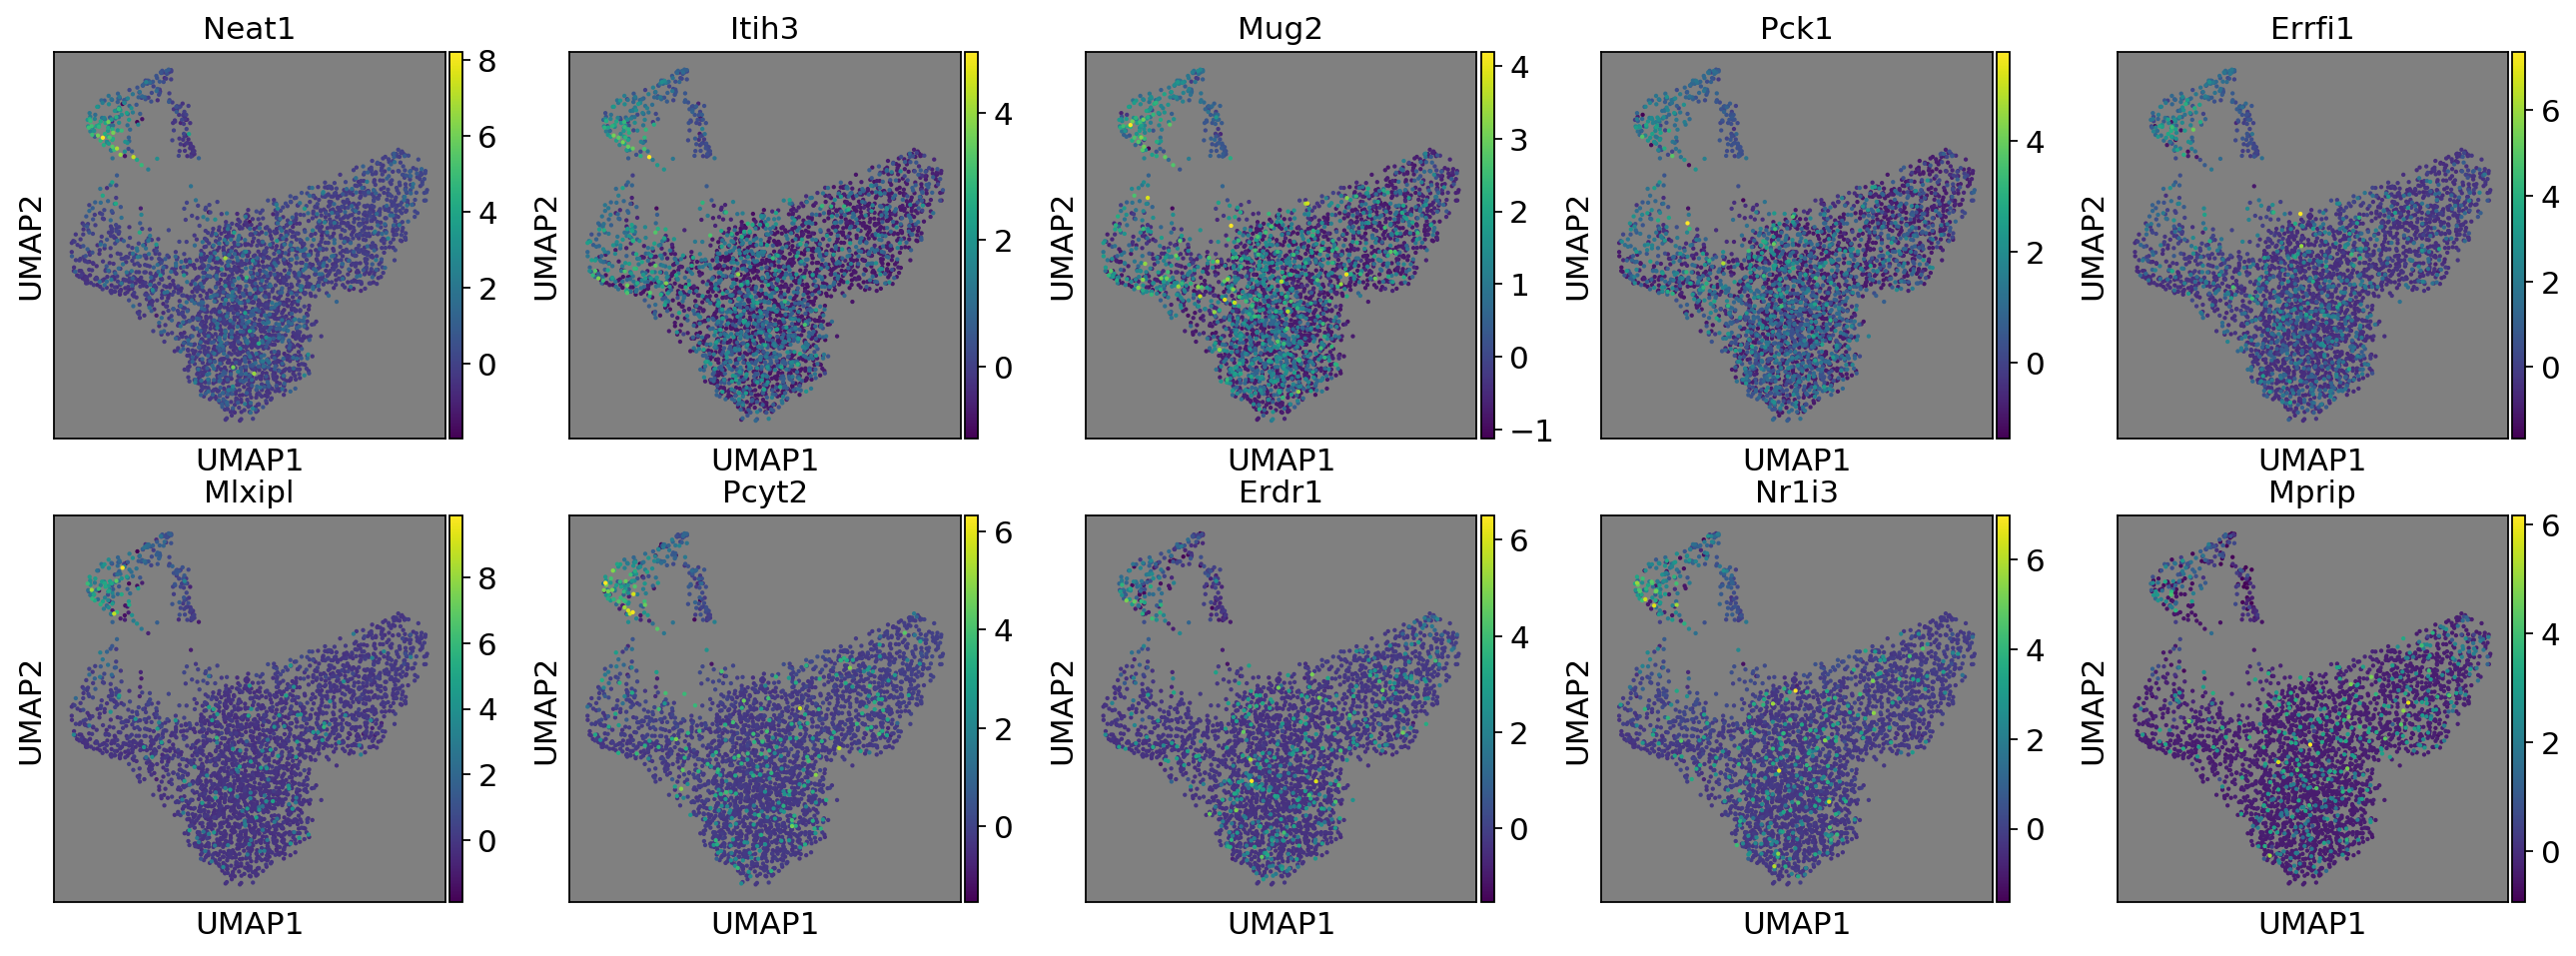

In [296]:
fig, axes = plt.subplots(2,5,figsize=(20,7))
for gene, ax in zip(liver.uns['rank_genes_groups']['names']['ct4'][:10], np.ravel(axes)):
    ax.set_facecolor('gray')
    sc.pl.umap(liver, color=gene, size=15, ax=ax, show=False, return_fig=False)

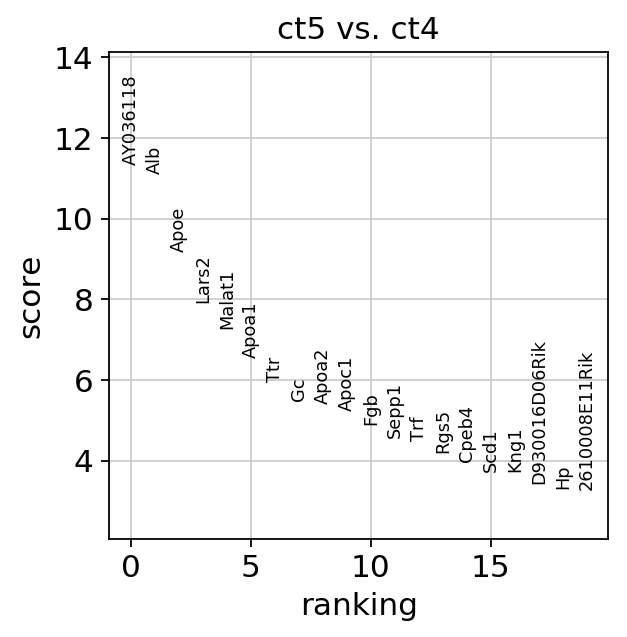

In [297]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(liver,groupby='celltype', groups=['ct5'],reference='ct4')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(liver)
sc.settings.verbosity = 3

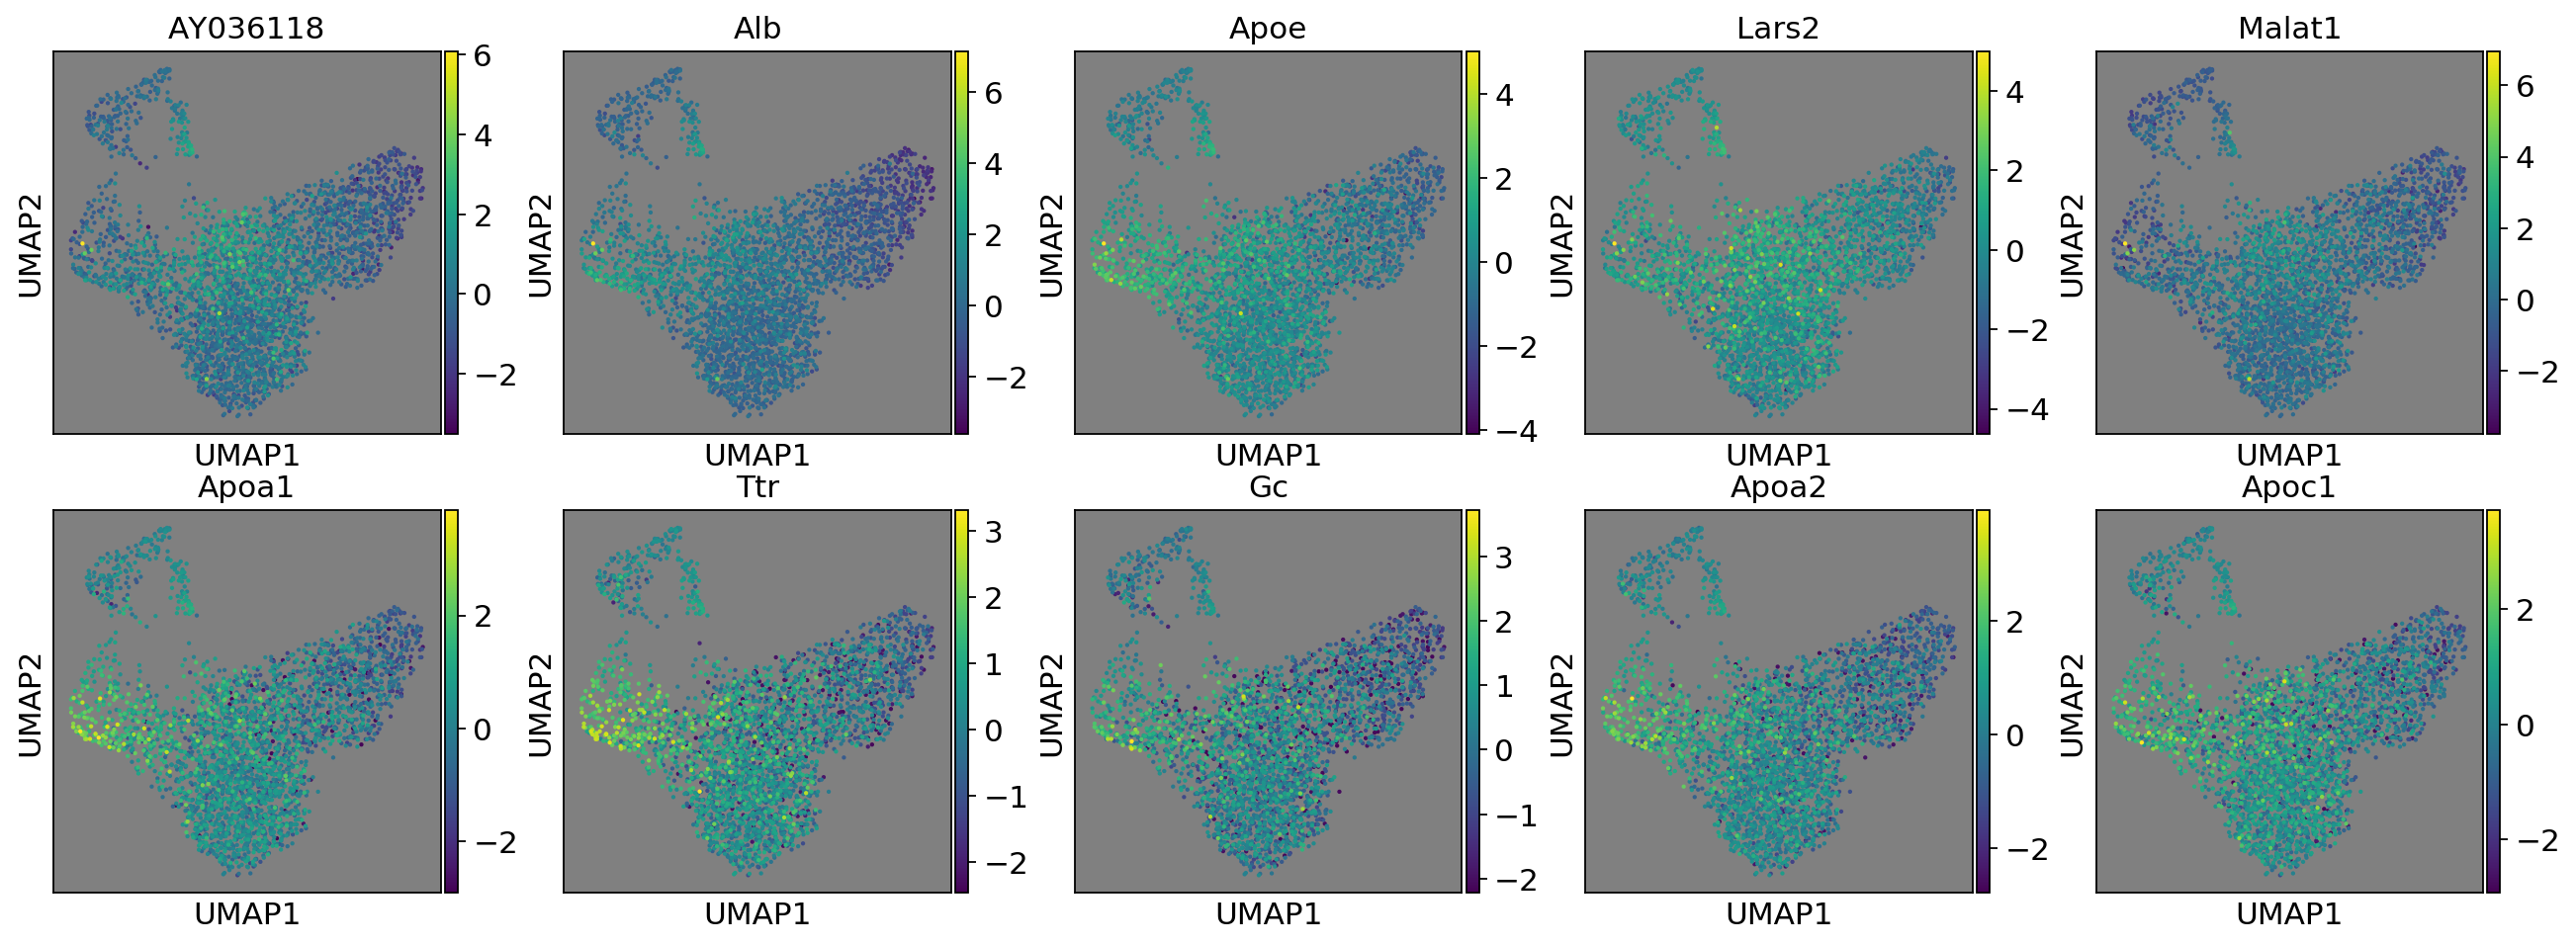

In [299]:
fig, axes = plt.subplots(2,5,figsize=(20,7))
for gene, ax in zip(liver.uns['rank_genes_groups']['names']['ct5'][:10], np.ravel(axes)):
    ax.set_facecolor('gray')
    sc.pl.umap(liver, color=gene, size=15, ax=ax, show=False, return_fig=False)

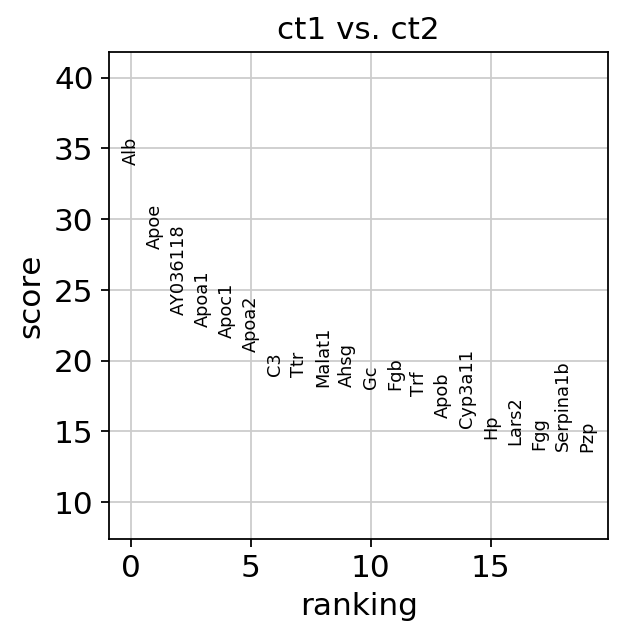

In [249]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(liver,groupby='celltype', groups=['ct1'],reference='ct2')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(liver)
sc.settings.verbosity = 3

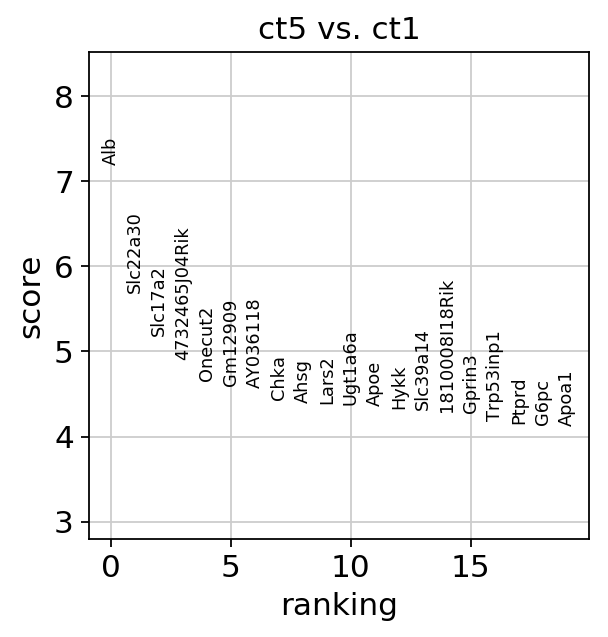

In [267]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(liver,groupby='celltype', groups=['ct5'],reference='ct1')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(liver)
sc.settings.verbosity = 3

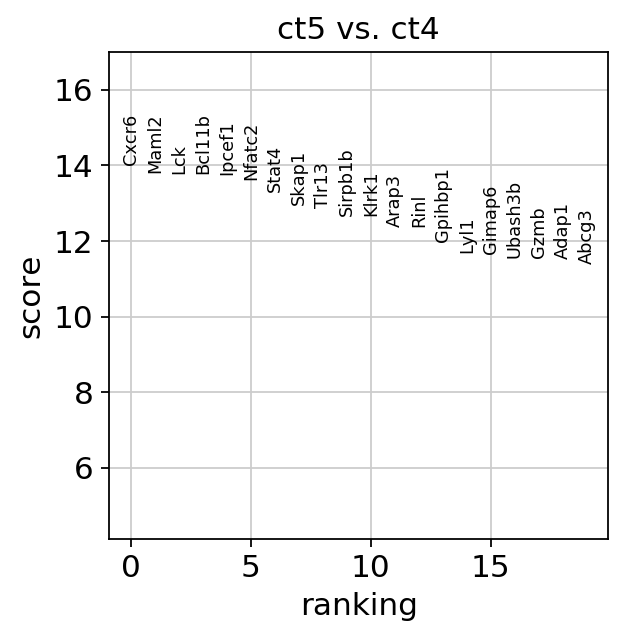

In [266]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(liver,groupby='celltype', groups=['ct5'],reference='ct4')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(liver)
sc.settings.verbosity = 3

In [ ]:
hv_adata = hv_run(exps[1]['adata'])

In [4]:
# for a rectangular gate:
xrange = (2e-2, 4)
yrange = (8e-1, 1e1)
gate1 = np.array([(xrange[0], yrange[0]), 
                  (xrange[0], yrange[1]), 
                  (xrange[1], yrange[1]), 
                  (xrange[1], yrange[0])])

In [ ]:
hv_plot(hv_adata, gate=gate1)

In [ ]:
genes = hv_genes(hv_adata, gate1)